# ECG MIT-BIH Arrhythmia Classification

In [2]:
# ECG MIT-BIH Arrhythmia Classification Notebook

## 🧩 1. Install Packages
print("installing")
!pip install wfdb shap numpy pandas scikit-learn matplotlib scipy tqdm

installing



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
## 📥 2. Import Libraries
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
print("imports done")

C:\Users\benaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


imports done


In [4]:

## 💾 3. Download MIT-BIH Record
import os
# Get all record numbers in the MIT-BIH Arrhythmia Database
db_path = 'mit-bih-arrhythmia-database-1.0.0'
if not os.path.exists(db_path):
    print("Downloading dataset from PhysioNet...")
    wfdb.dl_database('mitdb', dl_dir=db_path)

# List all record files (e.g., '100', '101', etc.)
record_list = [f.replace('.dat','') for f in os.listdir(db_path) if f.endswith('.dat')]
record_list = sorted(set(record_list))

fs = 360               # Sampling frequency (Hz)
max_duration = 2 * 60  # 2 minutes
max_samples = fs * max_duration

all_signals = []
all_annotations = []

for rec in record_list:
    try:
        print(f"Loading record {rec}...")
        record = wfdb.rdrecord(f"{db_path}/{rec}")
        ann = wfdb.rdann(f"{db_path}/{rec}", 'atr')

        sig = record.p_signal[:, 0]  # Use Lead 1
        sig = sig[:max_samples]      # Limit to 2 minutes

        # Keep annotations within 2-minute range
        ann_indices = [i for i in ann.sample if i < len(sig)]
        ann_symbols = [ann.symbol[i] for i in range(len(ann_indices))]

        all_signals.append(sig)
        all_annotations.append((ann_indices, ann_symbols))
    except Exception as e:
        print(f"⚠️ Skipping record {rec} due to error: {e}")

# Combine all loaded signals into one array
combined_signal = np.concatenate(all_signals)
print(f"\n✅ Loaded {len(all_signals)} records.")
print(f"✅ Combined signal length: {len(combined_signal)} samples (~{len(combined_signal)/fs/60:.2f} minutes total)")



Loading record 100...
Loading record 101...
Loading record 102...
Loading record 103...
Loading record 104...
Loading record 105...
Loading record 106...
Loading record 107...
Loading record 108...
Loading record 109...
Loading record 111...
Loading record 112...
Loading record 113...
Loading record 114...
Loading record 115...
Loading record 116...
Loading record 117...
Loading record 118...
Loading record 119...
Loading record 121...
Loading record 122...
Loading record 123...
Loading record 124...
Loading record 200...
Loading record 201...
Loading record 202...
Loading record 203...
Loading record 205...
Loading record 207...
Loading record 208...
Loading record 209...
Loading record 210...
Loading record 212...
Loading record 213...
Loading record 214...
Loading record 215...
Loading record 217...
Loading record 219...
Loading record 220...
Loading record 221...
Loading record 222...
Loading record 223...
Loading record 228...
Loading record 230...
Loading record 231...
Loading re

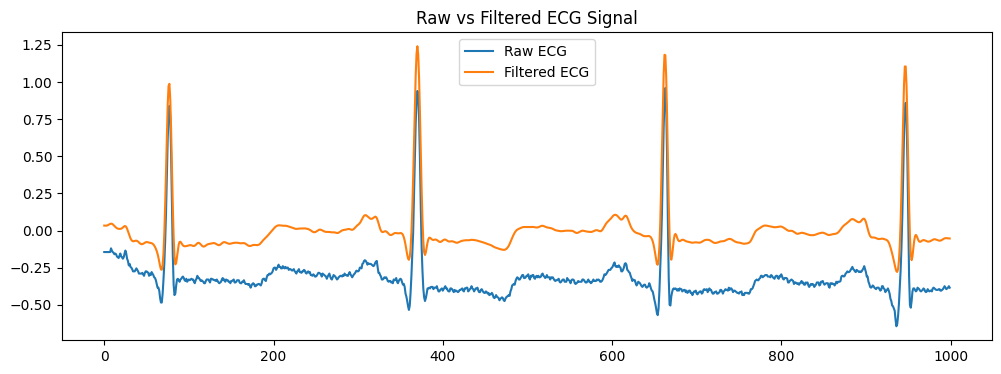

In [5]:

#4. Bandpass Filtering
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=360, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

ecgs = combined_signal
filtered_ecg = bandpass_filter(ecgs)
plt.figure(figsize=(12,4))
plt.plot(ecgs[:1000], label='Raw ECG')
plt.plot(filtered_ecg[:1000], label='Filtered ECG')
plt.legend()
plt.title('Raw vs Filtered ECG Signal')
plt.savefig("bandpass_plot.png", dpi=300, bbox_inches='tight')
plt.show()



In [10]:
#5. Noise augmentation

def add_gaussian_noise(sig, snr_db):
    sig_power = np.mean(sig**2)
    snr_linear = 10**(snr_db/10.0)
    noise_power = sig_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), size=sig.shape)
    return sig + noise

def add_baseline_drift(sig, fs=360, amp=0.2, freq=0.3):
    t = np.arange(len(sig)) / fs
    drift = amp * np.sin(2*np.pi*freq*t)
    return sig + drift

def add_powerline(sig, fs=360, amp=0.05, mains_freq=50.0):
    t = np.arange(len(sig)) / fs
    return sig + amp*np.sin(2*np.pi*mains_freq*t)

def add_motion_spikes(sig, n_spikes=5, amp_range=(0.5, 1.5)):
    sig2 = sig.copy()
    for _ in range(n_spikes):
        pos = np.random.randint(0, len(sig))
        amp = np.random.uniform(*amp_range)
        width = np.random.randint(1, int(len(sig)*0.001)+2)
        start = max(0, pos-width//2)
        end = min(len(sig), pos+width//2)
        sig2[start:end] += amp * np.sign(np.random.randn())
    return sig2

def random_augment(sig, fs=360):
    """Apply random subset of noise types."""
    out = sig.copy()
    if np.random.rand() < 0.5:
        out = add_gaussian_noise(out, snr_db=np.random.uniform(5,20))
    if np.random.rand() < 0.3:
        out = add_baseline_drift(out, fs, amp=np.random.uniform(0.05,0.3))
    if np.random.rand() < 0.3:
        out = add_powerline(out, fs, amp=np.random.uniform(0.02,0.1))
    if np.random.rand() < 0.3:
        out = add_motion_spikes(out, n_spikes=np.random.randint(1,6))
    return out


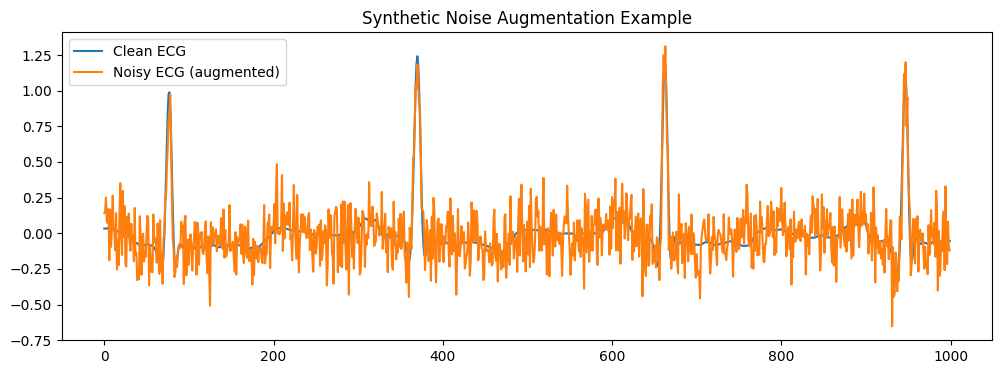

In [11]:
# 6. Visualize Augmentation Effects
fs = 360
noisy_ecg = random_augment(filtered_ecg.copy(), fs)

plt.figure(figsize=(12,4))
plt.plot(filtered_ecg[:1000], label='Clean ECG')
plt.plot(noisy_ecg[:1000], label='Noisy ECG (augmented)')
plt.legend()
plt.title('Synthetic Noise Augmentation Example')
plt.savefig("noise_aug.png", dpi=300, bbox_inches='tight')
plt.show()


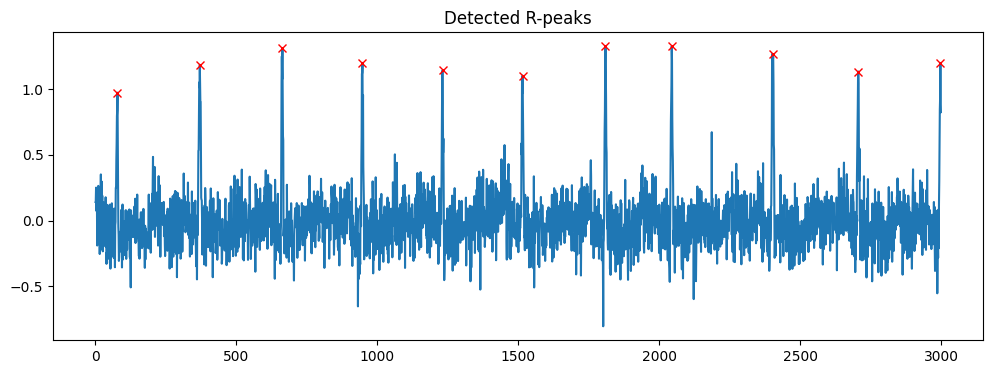

In [12]:

#7. R-Peak Detection and Visualization
peaks, _ = find_peaks(noisy_ecg, 
                      distance=200, 
                      height=np.mean(noisy_ecg)+0.3*np.std(noisy_ecg))
plt.figure(figsize=(12,4))
plt.plot(noisy_ecg[:3000])
plt.plot(peaks[peaks<3000], noisy_ecg[peaks[peaks<3000]], 'rx')
plt.title('Detected R-peaks')
plt.savefig("rpeaks.png", dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# 8. Features (Simpliefied HRV & Morphology)
rr_intervals = np.diff(peaks) / 360.0
features = pd.DataFrame({
    'mean_rr': [np.mean(rr_intervals)],
    'std_rr': [np.std(rr_intervals)],
    'min_rr': [np.min(rr_intervals)],
    'max_rr': [np.max(rr_intervals)],
})
print(features)

heart_rate = 60 / np.mean(rr_intervals)
print("Heart Rate:", heart_rate, "BPM")


    mean_rr    std_rr    min_rr  max_rr
0  0.770388  0.147747  0.555556   1.325
Heart Rate: 77.88284988214959 BPM


In [14]:
# 9. Extracting features and oversampling to handle imbalanced data 
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from imblearn.over_sampling import SMOTE
from collections import Counter

X_list, y_list = [], []

fs = 360
print("⏳ Extracting features from all records...")

for rec in record_list:
    try:
        record = wfdb.rdrecord(f"{db_path}/{rec}")
        ann = wfdb.rdann(f"{db_path}/{rec}", 'atr')
        sig = record.p_signal[:, 0][:max_samples]
        filtered_sig = bandpass_filter(sig)
        noisy_sig=random_augment(filtered_sig)
        peaks, _ = find_peaks(
            noisy_sig,
            distance=200,
            height=np.mean(noisy_sig) + 0.3 * np.std(noisy_sig)
        )

        if len(peaks) < 2:
            continue

        # Compute RR intervals
        rr_intervals = np.diff(peaks) / fs

        # Extract per-beat features
        for i in range(len(peaks) - 1):
            rr = rr_intervals[i]
            local_rr = rr_intervals[max(0, i - 3): i + 1]

            feat = [
                rr,
                np.std(local_rr),
                np.min(local_rr),
                np.max(local_rr)
            ]
            X_list.append(feat)

            # Find annotation for this beat
            beat_idx = peaks[i]
            closest_ann_idx = min(
                range(len(ann.sample)), 
                key=lambda j: abs(ann.sample[j] - beat_idx)
            )
            label = ann.symbol[closest_ann_idx]
            y_list.append(label)

    except Exception as e:
        print(f"⚠️ Skipping record {rec}: {e}")

# Convert to arrays
X = np.array(X_list)
y = np.array(y_list)

# Count occurrences of each class
class_counts = Counter(y)
print("Class counts before merging rare classes:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Merge classes that occur only once into "Other"
rare_classes = [cls for cls, count in class_counts.items() if count == 1]
y_merged = np.array([label if label not in rare_classes else "Other" for label in y])

print("\nClass counts after merging rare classes:")
print(Counter(y_merged))

# Handle imbalanced dataset with SMOTE
print("\nBefore Oversampling:", Counter(y_merged))
smote = SMOTE(random_state=42, k_neighbors=1)  # k_neighbors=1 for small classes
X_resampled, y_resampled = smote.fit_resample(X, y_merged)
print("After Oversampling:", Counter(y_resampled))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

print(f"\n✅ Prepared {len(X_resampled)} total samples from {len(record_list)} records.")
print(f"   Train: {len(X_train)} | Test: {len(X_test)}")
print(f"   Classes: {np.unique(y_resampled)}")


⏳ Extracting features from all records...
Class counts before merging rare classes:
N: 4894
A: 104
/: 465
f: 63
V: 350
+: 17
Q: 3
~: 5
x: 1
L: 486
F: 29
a: 2
R: 613
|: 3
!: 19
]: 1
": 15

Class counts after merging rare classes:
Counter({np.str_('N'): 4894, np.str_('R'): 613, np.str_('L'): 486, np.str_('/'): 465, np.str_('V'): 350, np.str_('A'): 104, np.str_('f'): 63, np.str_('F'): 29, np.str_('!'): 19, np.str_('+'): 17, np.str_('"'): 15, np.str_('~'): 5, np.str_('Q'): 3, np.str_('|'): 3, np.str_('Other'): 2, np.str_('a'): 2})

Before Oversampling: Counter({np.str_('N'): 4894, np.str_('R'): 613, np.str_('L'): 486, np.str_('/'): 465, np.str_('V'): 350, np.str_('A'): 104, np.str_('f'): 63, np.str_('F'): 29, np.str_('!'): 19, np.str_('+'): 17, np.str_('"'): 15, np.str_('~'): 5, np.str_('Q'): 3, np.str_('|'): 3, np.str_('Other'): 2, np.str_('a'): 2})
After Oversampling: Counter({np.str_('N'): 4894, np.str_('A'): 4894, np.str_('/'): 4894, np.str_('f'): 4894, np.str_('V'): 4894, np.str_('+')

Processing

RandomForest Performance
              precision    recall  f1-score   support

           !       0.99      0.99      0.99       964
           "       1.00      1.00      1.00       995
           +       0.99      1.00      0.99       933
           /       0.93      0.97      0.95       975
           A       0.99      0.99      0.99      1010
           F       1.00      1.00      1.00      1048
           L       0.91      0.95      0.93       972
           N       0.89      0.72      0.80       939
       Other       1.00      1.00      1.00      1000
           Q       1.00      1.00      1.00       968
           R       0.93      0.96      0.94       981
           V       0.95      0.97      0.96       984
           a       1.00      1.00      1.00       965
           f       0.99      0.99      0.99       951
           |       1.00      1.00      1.00      1001
           ~       1.00      1.00      1.00       975

    accuracy                           0.97

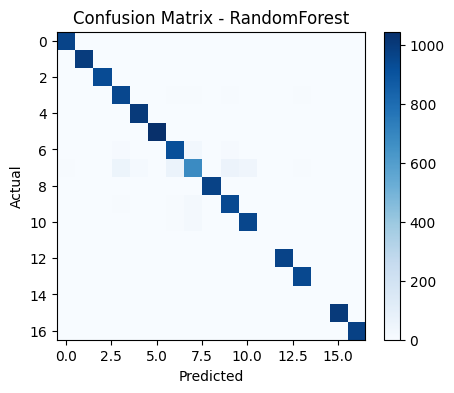


HistGradientBoosting Performance
              precision    recall  f1-score   support

           !       0.99      1.00      1.00       964
           "       1.00      1.00      1.00       995
           +       0.99      1.00      0.99       933
           /       0.89      0.97      0.93       975
           A       0.96      0.99      0.98      1010
           F       0.99      1.00      0.99      1048
           L       0.88      0.90      0.89       972
           N       0.86      0.60      0.71       939
       Other       1.00      1.00      1.00      1000
           Q       1.00      1.00      1.00       968
           R       0.89      0.92      0.91       981
           V       0.89      0.94      0.91       984
           a       1.00      1.00      1.00       965
           f       0.98      1.00      0.99       951
           |       1.00      1.00      1.00      1001
           ~       1.00      1.00      1.00       975

    accuracy                           0.96   

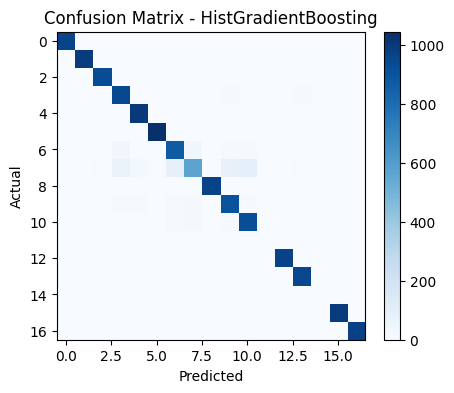

In [15]:
#10.  Train Multiple Models (RF + GradientBoosting)
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("Processing")
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.colorbar()
    plt.show()


In [16]:
import numpy as np
from collections import Counter

class RandomForestClassifier_manual:
    def __init__(self, n_estimators=10, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        np.random.seed(random_state)
        self.trees = []

    def _bootstrap(self, X, y):
        """Sample with replacement."""
        n_samples = X.shape[0]
        idx = np.random.choice(n_samples, n_samples, replace=True)
        return X[idx], y[idx]
    
    def _best_split(self, X, y):
        """Find best feature and threshold using Gini impurity."""
        best_feature, best_thresh, best_gini = None, None, 1e9
        n_features = X.shape[1]

        for f in range(n_features):
            thresholds = np.unique(X[:, f])
            for t in thresholds:
                left = y[X[:, f] <= t]
                right = y[X[:, f] > t]
                if len(left) == 0 or len(right) == 0:
                    continue
                gini = (len(left) * self._gini(left) + len(right) * self._gini(right)) / len(y)
                if gini < best_gini:
                    best_feature, best_thresh, best_gini = f, t, gini
        return best_feature, best_thresh

    def _gini(self, y):
        """Compute Gini impurity."""
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def _build_tree(self, X, y, depth):
        """Recursively build tree (dict-based)."""
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        feature, thresh = self._best_split(X, y)
        if feature is None:
            return Counter(y).most_common(1)[0][0]

        left_idx = X[:, feature] <= thresh
        right_idx = X[:, feature] > thresh

        return {
            "feature": feature,
            "thresh": thresh,
            "left": self._build_tree(X[left_idx], y[left_idx], depth + 1),
            "right": self._build_tree(X[right_idx], y[right_idx], depth + 1),
        }

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_s, y_s = self._bootstrap(X, y)
            tree = self._build_tree(X_s, y_s, depth=0)
            self.trees.append(tree)
        return self

    def _predict_tree(self, tree, x):
        if not isinstance(tree, dict):
            return tree
        if x[tree["feature"]] <= tree["thresh"]:
            return self._predict_tree(tree["left"], x)
        else:
            return self._predict_tree(tree["right"], x)

    def predict(self, X):
        preds = np.array([[self._predict_tree(tree, x) for tree in self.trees] for x in X])
        return np.array([Counter(p).most_common(1)[0][0] for p in preds])
print("Random Forest Classifier processing done")

Random Forest Classifier processing done


In [17]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class HistGradientBoostingClassifier_manual:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.classes_ = None

    def fit(self, X, y):
        # Convert labels to {0,1}
        self.classes_ = np.unique(y)
        y_bin = (y == self.classes_[1]).astype(int)

        # Start with initial log-odds
        p = np.clip(np.mean(y_bin), 1e-5, 1 - 1e-5)
        self.init_pred = np.log(p / (1 - p))
        F = np.full(len(y_bin), self.init_pred)

        for _ in range(self.n_estimators):
            # Compute pseudo-residuals (gradients)
            p = 1 / (1 + np.exp(-F))
            residuals = y_bin - p

            # Fit regression tree on residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)

            # Update model
            F += self.learning_rate * tree.predict(X)
        return self

    def predict_proba(self, X):
        F = np.full(X.shape[0], self.init_pred)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        p = 1 / (1 + np.exp(-F))
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.where(probs[:, 1] >= 0.5, self.classes_[1], self.classes_[0])
print("HistGradientBoosting processing done")

HistGradientBoosting processing done


In [18]:
def classification_report_manual(y_true, y_pred):
    labels = np.unique(y_true)
    report = {}
    for lbl in labels:
        tp = np.sum((y_true == lbl) & (y_pred == lbl))
        fp = np.sum((y_true != lbl) & (y_pred == lbl))
        fn = np.sum((y_true == lbl) & (y_pred != lbl))
        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        report[lbl] = {
            'precision': round(precision, 3),
            'recall': round(recall, 3),
            'f1-score': round(f1, 3),
            'support': np.sum(y_true == lbl)
        }
    accuracy = np.mean(y_true == y_pred)
    print(f"Accuracy: {accuracy:.3f}\n")
    for lbl, metrics in report.items():
        print(f"{lbl:10s}  P={metrics['precision']:.3f}  R={metrics['recall']:.3f}  F1={metrics['f1-score']:.3f}  Support={metrics['support']}")
print("Processing done")

Processing done


In [19]:
#REDUCING THE NUMBER OF SAMPLES SO THAT THE MANUAL CODE FINISHES PROCESSING AS IT IS 100X SLOWER THAN SK-LEARN

# Shuffle the full training set first
idx = np.random.permutation(len(X_train))
X_train_shuffled = X_train[idx]
y_train_shuffled = y_train[idx]

# Take a small but representative subset
n_train_small = 5000  
n_test_small = 1000     # enough to evaluate accuracy

X_train_small = X_train_shuffled[:n_train_small]
y_train_small = y_train_shuffled[:n_train_small]

X_test_small = X_test[:n_test_small]
y_test_small = y_test[:n_test_small]


print("Processing...")
rf_manual = RandomForestClassifier_manual(
    n_estimators=5,    
    max_depth=5,         
    random_state=42
)
rf_manual.fit(X_train_small, y_train_small)
y_pred_rf = rf_manual.predict(X_test_small)
print("\n RandomForest (Manual)")
classification_report_manual(y_test_small, y_pred_rf)
print("RandomForest processing done")

print("Processing...")

hgb_manual = HistGradientBoostingClassifier_manual(
    n_estimators=10,    
    learning_rate=0.1,   
    max_depth=5
)
hgb_manual.fit(X_train_small, y_train_small)
y_pred_hgb = hgb_manual.predict(X_test_small)
print("\n HistGradientBoosting (Manual)")
classification_report_manual(y_test_small, y_pred_hgb)
print("HistGraidentBoosting processing done")



Processing...

 RandomForest (Manual)
Accuracy: 0.594

!           P=0.506  R=0.661  F1=0.574  Support=59
"           P=0.864  R=1.000  F1=0.927  Support=70
+           P=0.641  R=0.481  F1=0.549  Support=52
/           P=0.516  R=0.653  F1=0.576  Support=75
A           P=0.258  R=0.143  F1=0.184  Support=56
F           P=0.506  R=0.534  F1=0.520  Support=73
L           P=0.310  R=0.600  F1=0.409  Support=60
N           P=0.000  R=0.000  F1=0.000  Support=58
Other       P=0.894  R=0.756  F1=0.819  Support=78
Q           P=1.000  R=1.000  F1=1.000  Support=57
R           P=0.422  R=0.415  F1=0.419  Support=65
V           P=0.333  R=0.029  F1=0.053  Support=69
a           P=0.760  R=1.000  F1=0.864  Support=57
f           P=0.618  R=0.557  F1=0.586  Support=61
|           P=0.657  R=0.917  F1=0.765  Support=48
~           P=0.511  R=0.774  F1=0.615  Support=62
RandomForest processing done
Processing...

 HistGradientBoosting (Manual)
Accuracy: 0.059

!           P=0.059  R=1.000  F1=0.11


🔹 Explaining class '!'

SHAP for RandomForest - class '!'


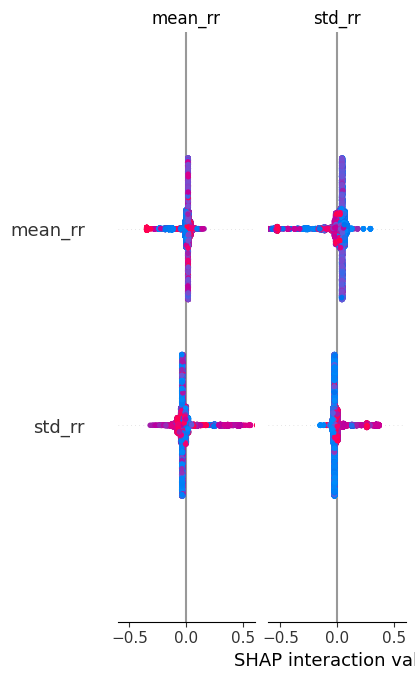


SHAP for HistGradientBoosting - class '!'


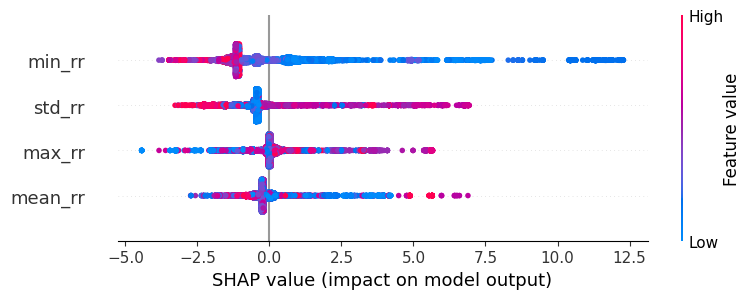


🔹 Explaining class '"'

SHAP for RandomForest - class '"'


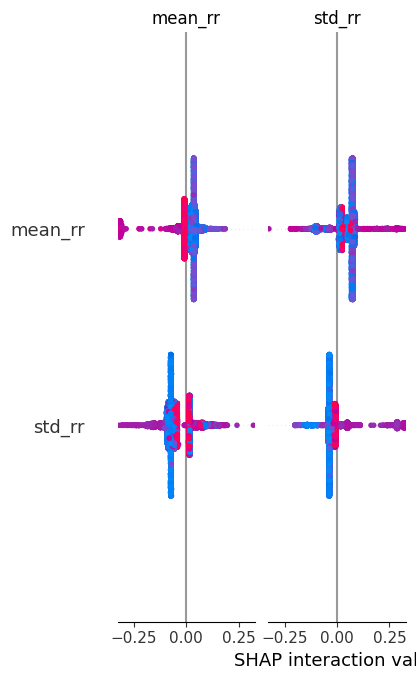


SHAP for HistGradientBoosting - class '"'


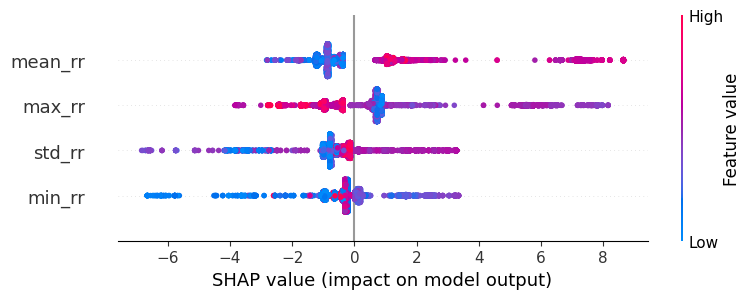


🔹 Explaining class '+'

SHAP for RandomForest - class '+'


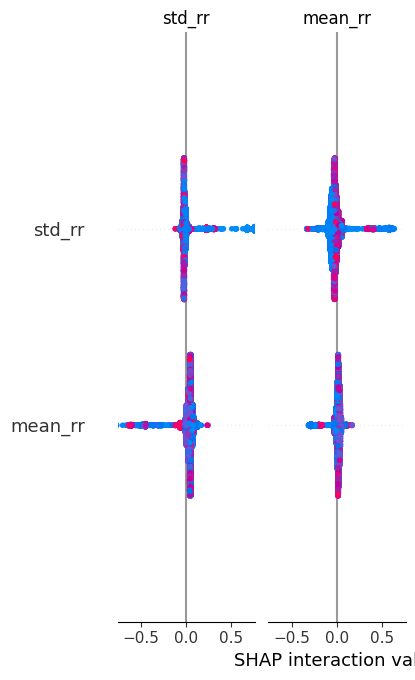


SHAP for HistGradientBoosting - class '+'


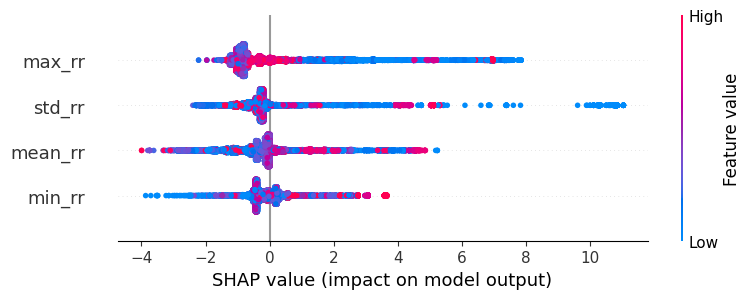


🔹 Explaining class '/'

SHAP for RandomForest - class '/'


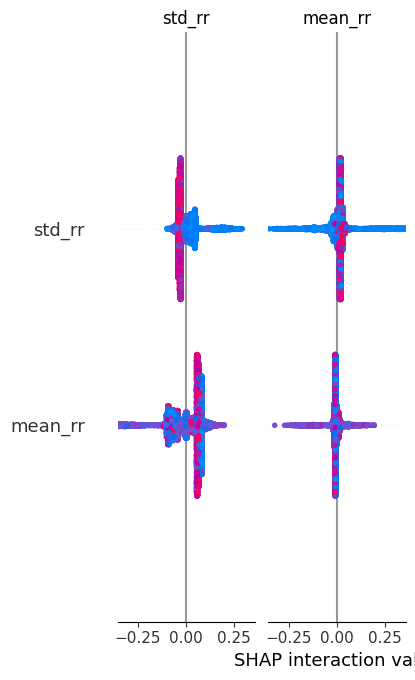


SHAP for HistGradientBoosting - class '/'


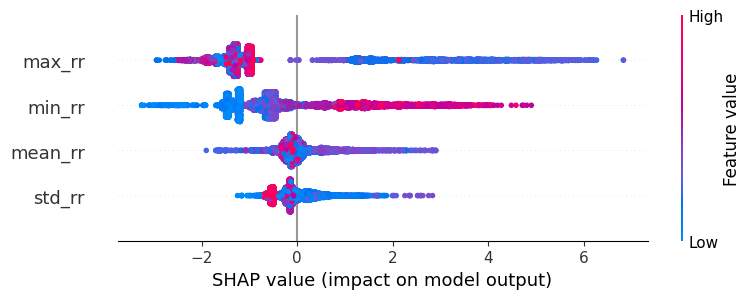


🔹 Explaining class 'A'

SHAP for RandomForest - class 'A'


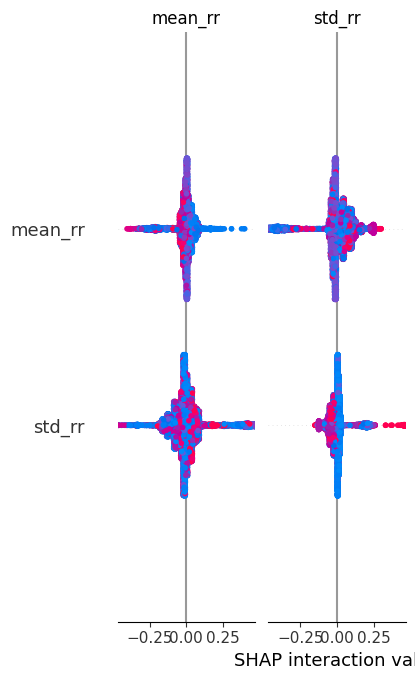


SHAP for HistGradientBoosting - class 'A'


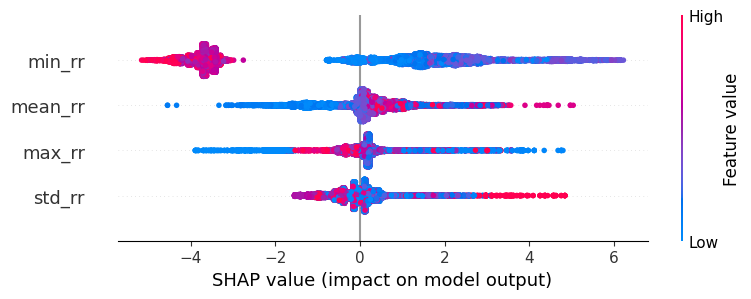


🔹 Explaining class 'F'

SHAP for RandomForest - class 'F'


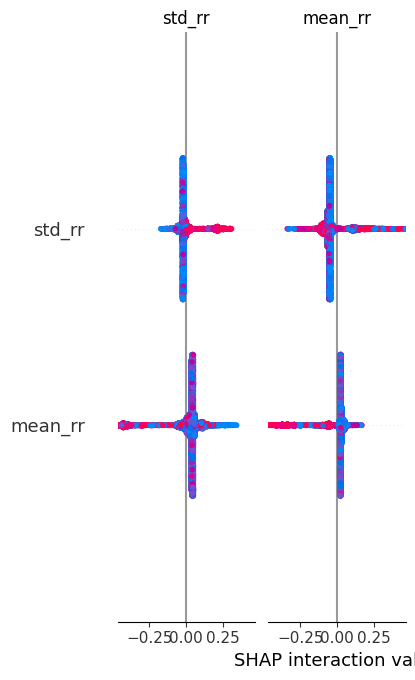


SHAP for HistGradientBoosting - class 'F'


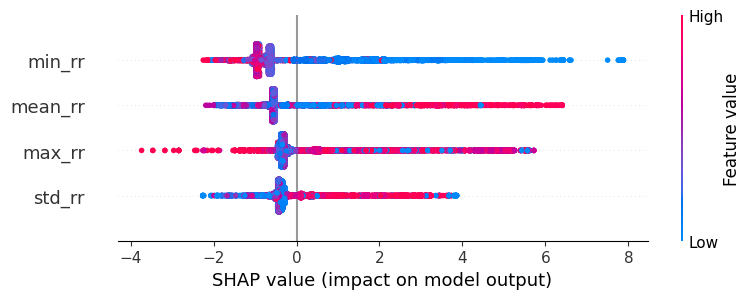


🔹 Explaining class 'L'

SHAP for RandomForest - class 'L'


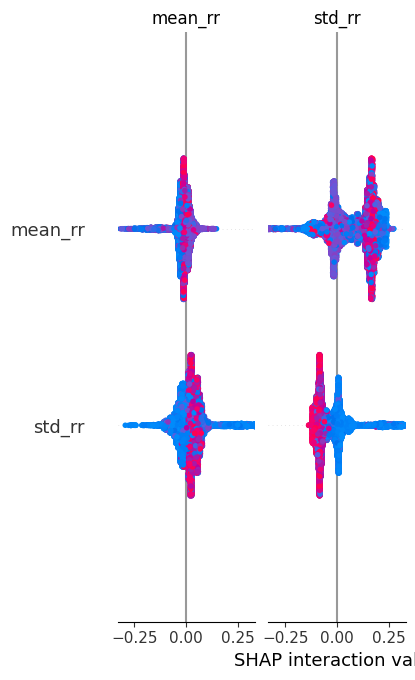


SHAP for HistGradientBoosting - class 'L'


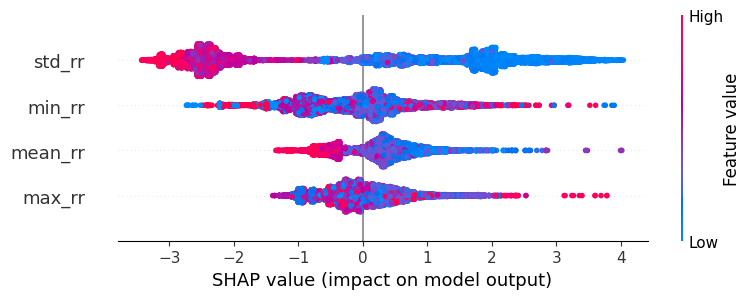


🔹 Explaining class 'N'

SHAP for RandomForest - class 'N'


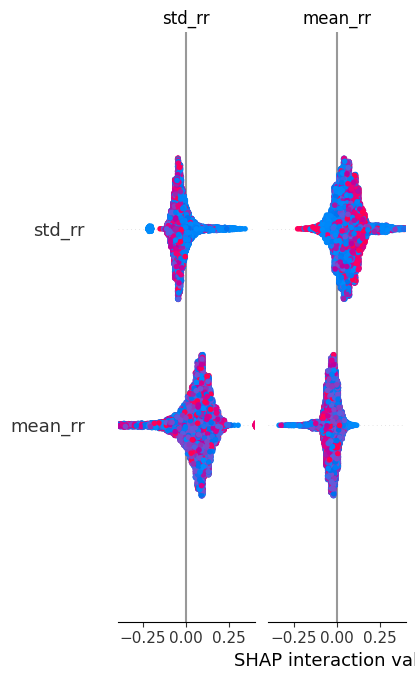


SHAP for HistGradientBoosting - class 'N'


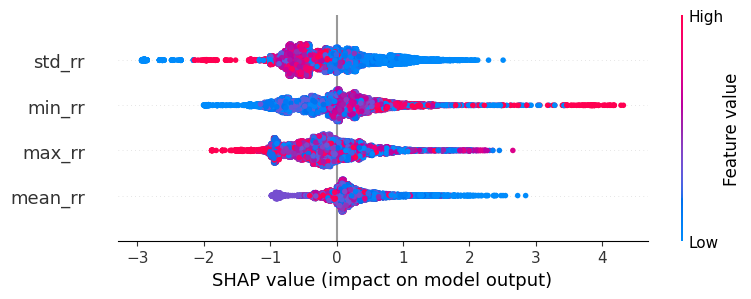


🔹 Explaining class 'Other'

SHAP for RandomForest - class 'Other'


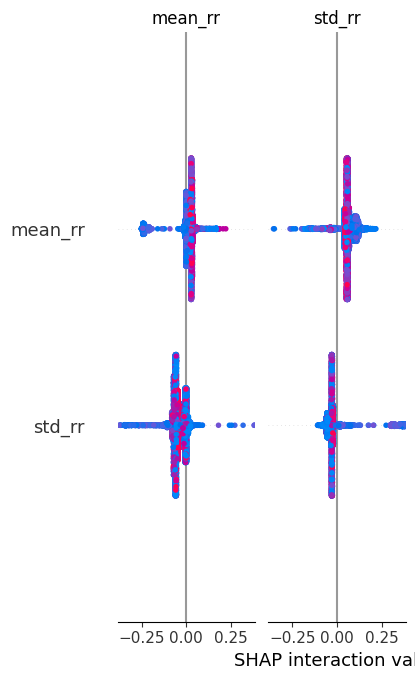


SHAP for HistGradientBoosting - class 'Other'


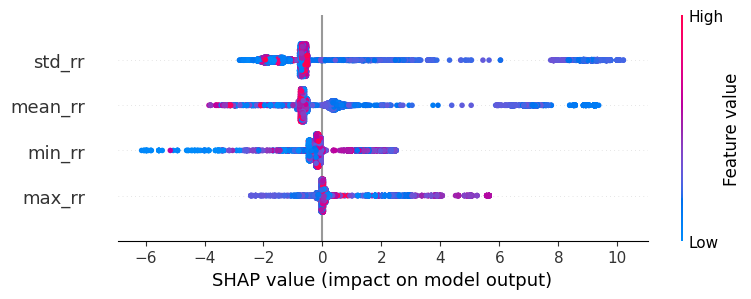


🔹 Explaining class 'Q'

SHAP for RandomForest - class 'Q'


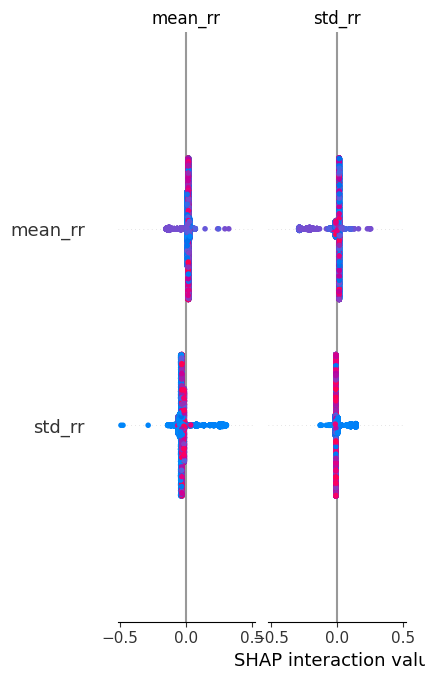


SHAP for HistGradientBoosting - class 'Q'


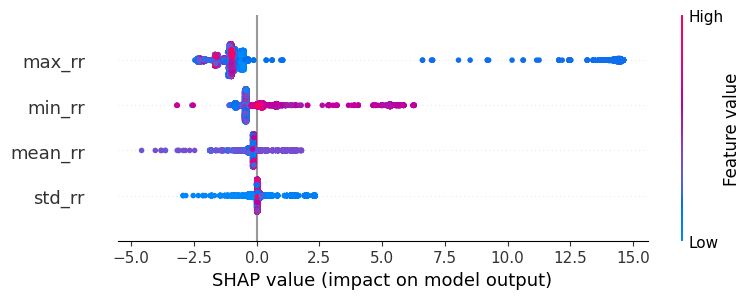


🔹 Explaining class 'R'

SHAP for RandomForest - class 'R'


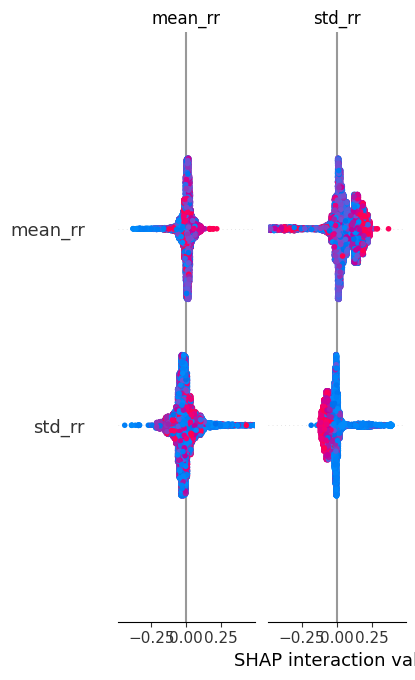


SHAP for HistGradientBoosting - class 'R'


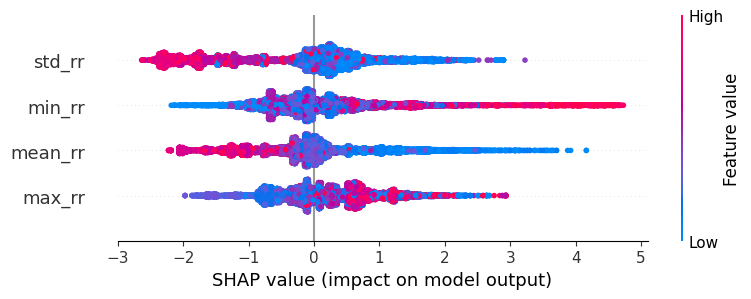


🔹 Explaining class 'V'

SHAP for RandomForest - class 'V'


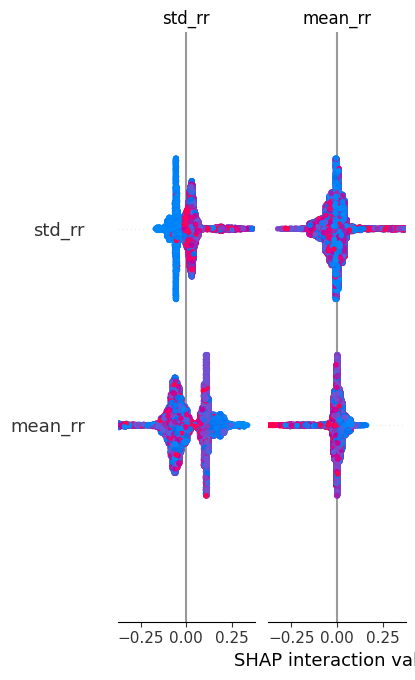


SHAP for HistGradientBoosting - class 'V'


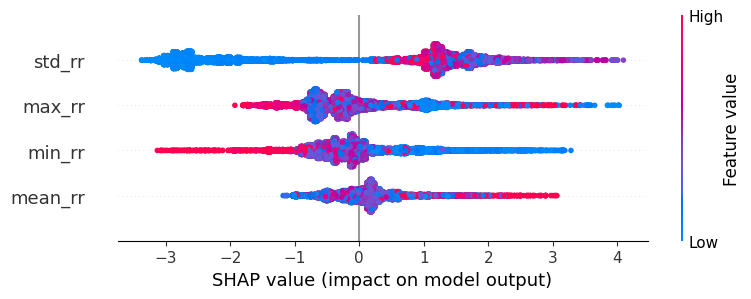


🔹 Explaining class 'f'

SHAP for RandomForest - class 'f'


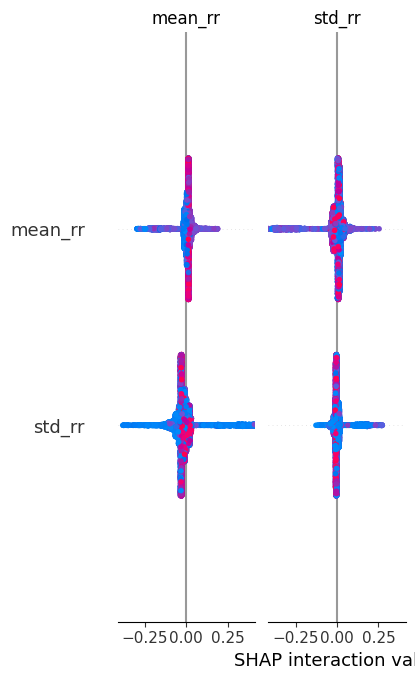


SHAP for HistGradientBoosting - class 'f'


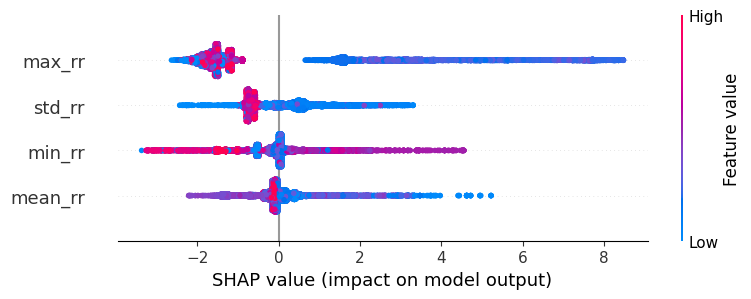


🔹 Explaining class '|'

SHAP for RandomForest - class '|'


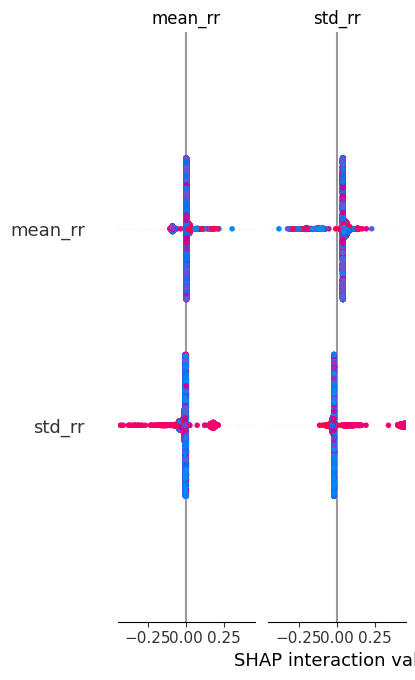


SHAP for HistGradientBoosting - class '|'


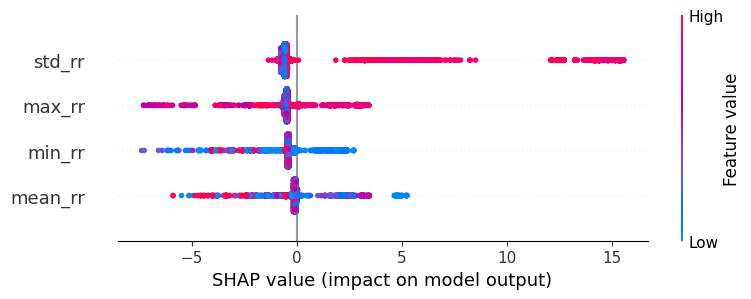


🔹 Explaining class '~'

SHAP for RandomForest - class '~'


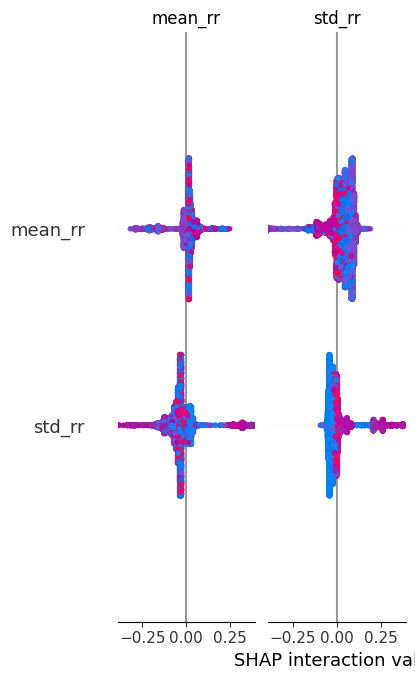


SHAP for HistGradientBoosting - class '~'


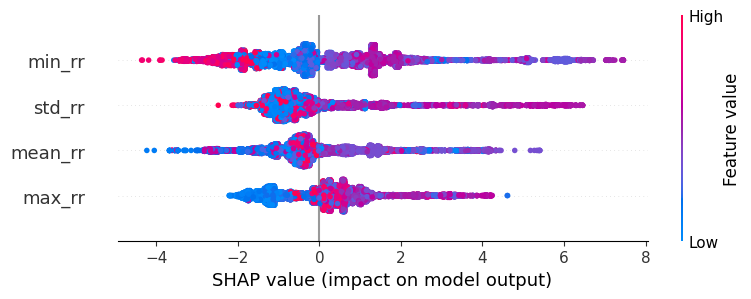

In [15]:

# 12. SHAP Explainability for Both Models
import shap
import pandas as pd
import numpy as np

feature_names = ['mean_rr', 'std_rr', 'min_rr', 'max_rr']
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X_train_df = pd.DataFrame(X_train, columns=feature_names)

classes = np.unique(y_train)  # all classes in your dataset

for cls in classes:
    print(f"\n🔹 Explaining class '{cls}'")

    # Convert to binary labels for current class
    y_train_bin = (y_train == cls).astype(int)
    y_test_bin = (y_test == cls).astype(int)

    # Train binary RandomForest
    rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_bin.fit(X_train_df, y_train_bin)

    # Train binary HistGradientBoosting
    hgb_bin = HistGradientBoostingClassifier(random_state=42)
    hgb_bin.fit(X_train_df, y_train_bin)

    for name, model in zip(['RandomForest', 'HistGradientBoosting'], [rf_bin, hgb_bin]):
        print(f"\nSHAP for {name} - class '{cls}'")
        try:
            explainer = shap.TreeExplainer(model, model_output="raw")
            shap_values = explainer.shap_values(X_test_df)

            # Plot SHAP summary
            shap.summary_plot(shap_values, X_test_df, feature_names=feature_names, show=True)

        except Exception as e:
            print(f"SHAP failed for {name}, class '{cls}': {e}")




In [20]:

# 13. Save Outputs for Both Models
print("running")
for name, model in models.items():
    y_pred = model.predict(X_test)
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    results_df.to_csv(f'ecg_results_{name}.csv', index=False)
    print(f'Results saved as ecg_results_{name}.csv')


running
Results saved as ecg_results_RandomForest.csv
Results saved as ecg_results_HistGradientBoosting.csv


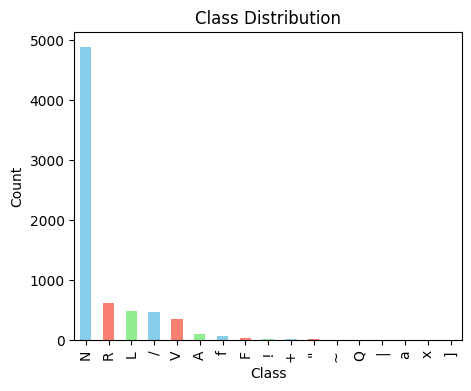

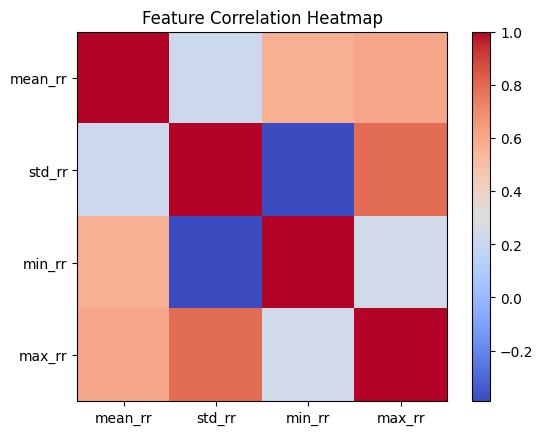

In [21]:

# 14. Extra Visualization: Class Distribution & Feature Correlation
class_counts = pd.Series(y).value_counts()
plt.figure(figsize=(5,4))
class_counts.plot(kind='bar', color=['skyblue','salmon','lightgreen'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig("class distribution", dpi=300, bbox_inches='tight')
plt.show()

corr = pd.DataFrame(X, columns=['mean_rr','std_rr','min_rr','max_rr']).corr()
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Feature Correlation Heatmap')
plt.xticks(range(4), corr.columns)
plt.yticks(range(4), corr.columns)
plt.show()
